### Connecting Counterfactuals to Machine Learning

🎯 Learning Goals:

Link causal inference to machine learning prediction.

See how a model can predict outcomes accurately but still give biased causal effects.

Practice regression modeling and model interpretation in Python.

#### Imports

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [9]:
# Creating a random seed and other paramters
random.seed(42)

n = 1000

# Simulate ability
ability = np.random.normal(loc=0, scale=1, size=n)

In [23]:
# Simulate treatment: higher ability -> higher chance of treatment
p_treat = 1 / (1 + np.exp(-(-0.5 + 1.2 * ability)))
treat = np.random.binomial(1, p_treat, size=n)
income = 3 + 2 * treat + 1.5 * ability + np.random.normal(0, 1, size=n)

In [26]:
#Creating a dataframe
df = pd.DataFrame({
    'ability': ability,
    'treat': treat,
    'income': income
})

In [28]:
df.head()

,ability,treat,income
0,0.285894,0,4.005474
1,0.156724,0,3.655059
2,0.540182,0,4.343728
3,0.125996,0,3.258086
4,0.807063,0,4.014030


In [29]:
df.describe()

,ability,treat,income
count,1000.000000,1000.000000,1000.000000
mean,-0.036493,0.400000,3.743974
std,1.007833,0.490143,2.442641
min,-3.649950,0.000000,-3.267986
25%,-0.727182,0.000000,1.969228
50%,-0.033953,0.000000,3.551329
75%,0.656479,1.000000,5.463326
max,2.950537,1.000000,10.848405


#### Train Test Split

In [37]:
# Sorting out X and y
X = df[['treat', 'ability']]
y = df['income']

In [38]:
#Train - Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Naive Model

In [47]:
# Only includes treat → coefficient is biased because it doesn’t control for ability.
model_naive = LinearRegression().fit(X_train[['treat']], y_train)
y_pred_naive = model_naive.predict(X_test[['treat']])
coef_naive = model_naive.coef_[0]
mse_naive = mean_squared_error(y_test, y_pred_naive)

In [52]:
# Including ability isolates the true causal effect of treat.
model_controlled = LinearRegression().fit(X_train, y_train)
y_pred_controlled = model_controlled.predict(X_test)
coef_controlled = model_controlled.coef_[0]  # coefficient for treat
mse_controlled = mean_squared_error(y_test, y_pred_controlled)

#### Results

In [53]:
print(f"Naive treat coefficient: {coef_naive:.3f}, MSE: {mse_naive:.3f}")
print(f"Controlled treat coefficient: {coef_controlled:.3f}, MSE: {mse_controlled:.3f}")

Naive treat coefficient: 3.576, MSE: 2.609
Controlled treat coefficient: 1.986, MSE: 0.944


In [54]:
print("Prediction MSE comparison:")
print(f"Naive MSE: {mse_naive:.3f}")
print(f"Controlled MSE: {mse_controlled:.3f}")

print("Causal effect bias:")
print(f"Naive bias: {coef_naive - 2:.3f}")
print(f"Controlled bias: {coef_controlled - 2:.3f}")

Prediction MSE comparison:
Naive MSE: 2.609
Controlled MSE: 0.944
Causal effect bias:
Naive bias: 1.576
Controlled bias: -0.014


#### Plotting

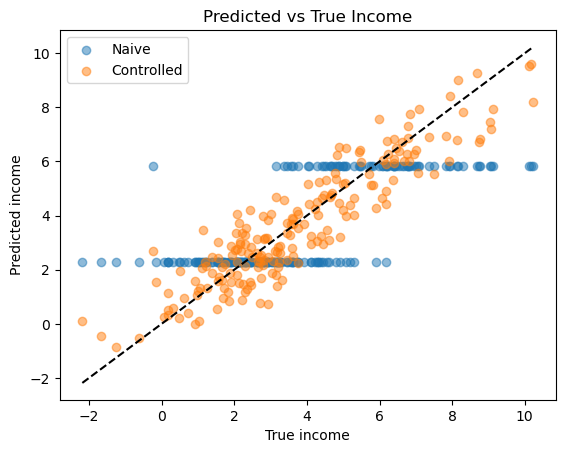

In [56]:
plt.scatter(y_test, y_pred_naive, alpha=0.5, label='Naive')
plt.scatter(y_test, y_pred_controlled, alpha=0.5, label='Controlled')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('True income')
plt.ylabel('Predicted income')
plt.legend()
plt.title('Predicted vs True Income')
plt.show()

#### Building a Random Forest Predictor of Naive Model

In [70]:
rf_naive = RandomForestRegressor(n_estimators=100, random_state=42)
rf_naive.fit(X_train[['treat']], y_train)

y_pred_naive = rf_naive.predict(X_test[['treat']])
mse_naive = mean_squared_error(y_test, y_pred_naive)

In [71]:
print(f"Naive Random Forest MSE: {mse_naive:.3f}")

Naive Random Forest MSE: 2.611


Predicts income without controlling for ability, so treatment effect is biased if you try to interpret it causally.

In [74]:
rf_controlled = RandomForestRegressor(n_estimators=100, random_state=42)
rf_controlled.fit(X_train, y_train)

y_pred_controlled = rf_controlled.predict(X_test)
mse_controlled = mean_squared_error(y_test, y_pred_controlled)

In [75]:
print(f"Controlled Random Forest MSE: {mse_controlled:.3f}")

Controlled Random Forest MSE: 1.379


#### Estimate treatment effect from ML models

1. ML models don’t directly give “coefficients” like linear regression.
2. Two common ways to estimate treatment effect:

In [76]:
# Naive: predicted difference if treated vs not treated
X_test_naive_treated = X_test[['treat']].copy()
X_test_naive_treated['treat'] = 1
X_test_naive_control = X_test[['treat']].copy()
X_test_naive_control['treat'] = 0

effect_naive = np.mean(rf_naive.predict(X_test_naive_treated) - 
                       rf_naive.predict(X_test_naive_control))
print(f"Naive ML estimated effect: {effect_naive:.3f}")

Naive ML estimated effect: 3.565


In [78]:
X_test_controlled_treated = X_test.copy()
X_test_controlled_treated['treat'] = 1
X_test_controlled_control = X_test.copy()
X_test_controlled_control['treat'] = 0

effect_controlled = np.mean(rf_controlled.predict(X_test_controlled_treated) - 
                            rf_controlled.predict(X_test_controlled_control))
print(f"Controlled ML estimated effect: {effect_controlled:.3f}")

Controlled ML estimated effect: 2.121
